## 一、从零开始实现批量归一化

In [10]:
import torch
from torch import nn
from d2l import torch as d2l

#### 1. 归一化操作

In [21]:
def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    # 通过is_grad_enabled来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X - moving_mean) / torch.sqrt(moving_var + eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上（axis=1）的均值和方差。
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X - mean) ** 2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下，用当前的均值和方差做标准化
        X_hat = (X - mean) / torch.sqrt(var + eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta  # 缩放和移位
    return Y, moving_mean.data, moving_var.data

#### 2. 批量归一化层

In [22]:
class BatchNorm(nn.Module):
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:
            shape = (1, num_features)
        else:
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸和偏移参数，分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)

    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(
            X, self.gamma, self.beta, self.moving_mean,
            self.moving_var, eps=1e-5, momentum=0.9)
        return Y

#### 3. 应用模型到LeNet网络

In [23]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10))

#### 4. 训练

In [24]:
class Animator:
    """For plotting data in animation."""

    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        # d2l.display.display(self.fig)
        # d2l.display.clear_output(wait=True)
        
        
def train_ch6(net, train_iter, test_iter, num_epochs, lr, device):
    """用GPU训练模型"""

    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel='epoch',
                        xlim=[1, num_epochs],
                        legend=['train loss', 'train acc', 'test acc'])
    timer, num_batches = d2l.Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # 训练损失之和，训练准确率之和，样本数
        metric = d2l.Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (train_l, train_acc, None))
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f'loss\t \t {train_l:.3f}')
    print(f'train acc\t {train_acc:.3f}')
    print(f'test acc\t {test_acc:.3f}')
    print(f'({metric[2] * num_epochs / timer.sum():.1f} examples/sec on {str(device)})')

loss	 	 0.263
train acc	 0.902
test acc	 0.858
(25115.5 examples/sec on cuda:3)


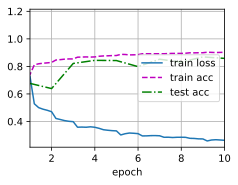

In [25]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu(3))

# 二、简洁实现

In [26]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(256, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10))

loss	 	 0.263
train acc	 0.902
test acc	 0.878
(42150.8 examples/sec on cuda:3)


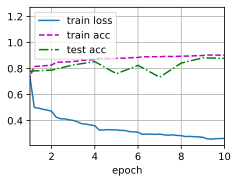

In [27]:
train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu(3))